In [10]:
!pip install diffusers transformers accelerate datasets ftfy tokenizers safetensors torchvision pillow einops -q

In [24]:
import os
import re
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from accelerate import Accelerator
from sklearn.model_selection import train_test_split
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel
from datasets import load_dataset
from datetime import datetime
from tqdm import tqdm

### Config

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")  # for text encoder
BATCH_SIZE = 8
NUM_EPOCHS = 2
LR = 2e-5
GUIDANCE_PROB = 0.15
NULL_TOKEN = ""
CHECKPOINT_DIR = "checkpoints"
SAMPLES_DIR = "milestone2_samples"
CSV_LOG = "train_log.csv"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(SAMPLES_DIR, exist_ok=True)

In [13]:
print("CUDA:", torch.version.cuda)
print("Torch:", torch.__version__)
print("Device:", torch.cuda.get_device_name(0))
print("Compute Capability:", torch.cuda.get_device_capability(0))

CUDA: 12.8
Torch: 2.8.0+cu128
Device: Tesla P100-PCIE-12GB
Compute Capability: (6, 0)


### Load and Preprocess data

Total examples: 6357

Available keys: dict_keys(['image', 'caption', 'sentids', 'img_id', 'filename'])


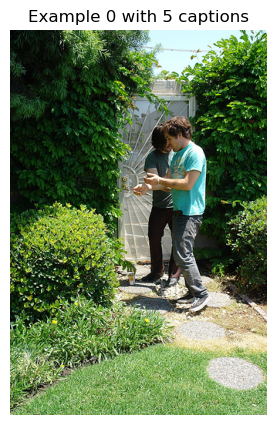


--- Example 0 Captions ---
1. Two young guys with shaggy hair look at their hands while hanging out in the yard .
2. Two young  White males are outside near many bushes .
3. Two men in green shirts are standing in a yard .
4. A man in a blue shirt standing in a garden .
5. Two friends enjoy time spent together .


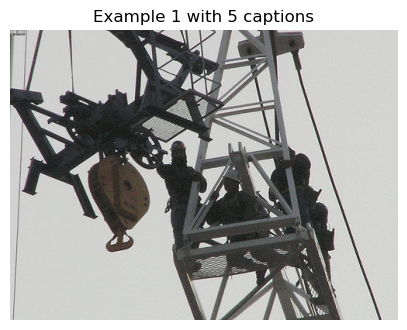


--- Example 1 Captions ---
1. Several men in hard hats are operating a giant pulley system .
2. Workers look down from up above on a piece of equipment .
3. Two men working on a machine wearing hard hats .
4. Four men on top of a tall structure .
5. Three men on a large rig .


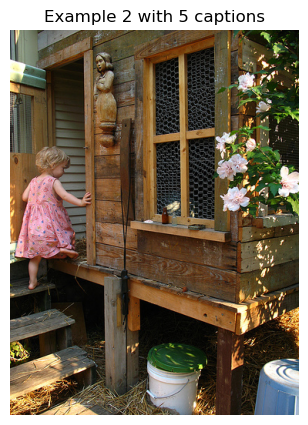


--- Example 2 Captions ---
1. A child in a pink dress is climbing up a set of stairs in an entry way .
2. A little girl in a pink dress going into a wooden cabin .
3. A little girl climbing the stairs to her playhouse .
4. A little girl climbing into a wooden playhouse 
5. A girl going into a wooden building .


In [14]:
try:
    dataset = load_dataset("lmms-lab/flickr30k", split="test[:20%]")
    
    print(f"Total examples: {len(dataset)}")
    
    example = dataset[0]
    print(f"\nAvailable keys: {example.keys()}")
    
    for i in range(3):
        ex = dataset[i]
        image = ex["image"]
        captions = ex.get("caption", ex.get("captions", []))
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Example {i} with {len(captions)} captions", fontsize=12)
        plt.show()

        print(f"\n--- Example {i} Captions ---")
        if isinstance(captions, list):
            for j, c in enumerate(captions):
                print(f"{j+1}. {c}")
        else:
            print(captions)
        
except Exception as e:
    print(f"Error: {e}")
    print("\nTry alternative approach...")

In [15]:
print(dataset)

Dataset({
    features: ['image', 'caption', 'sentids', 'img_id', 'filename'],
    num_rows: 6357
})


In [16]:
def clean_caption(caption):
    caption = caption.lower().strip()
    caption = re.sub(r'[^a-z0-9\s.,!?-]', '', caption)
    return ' '.join(caption.split())

In [19]:
pairs = []
for example in dataset:
    image = example["image"]
    if image.mode != 'RGB':
        image = image.convert('RGB')
    for caption in example["caption"]:
        cleaned = clean_caption(caption)
        if 5 <= len(cleaned.split()) <= 50:
            pairs.append({'image': image, 'caption': cleaned})

In [22]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}")

Train: 25356, Val: 6339


### Create dataset

In [25]:
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

class ImageCaptionDataset(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        image = self.transform(pair['image']) if self.transform else pair['image']
        return {'image': image, 'caption': pair['caption']}

In [26]:
train_dataset = ImageCaptionDataset(train_pairs, image_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Load CLIP

In [37]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float32
).to(cpu_device)
text_encoder.eval()

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

### Text -> Embedding function

In [38]:
def get_text_embeddings(captions):
    tokens = tokenizer(
        captions, 
        padding="max_length", 
        max_length=77,
        truncation=True, 
        return_tensors="pt"
    )
    tokens = {k: v.to(cpu_device) for k, v in tokens.items()}
    with torch.no_grad():
        outputs = text_encoder(
            tokens['input_ids'], 
            attention_mask=tokens['attention_mask']
        )
    return outputs.last_hidden_state

### Load Stable Diffusion

In [43]:
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="vae"
).to(cpu_device)
vae = vae.to(cpu_device)  
vae.eval()

unet = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    subfolder="unet"
).to(cpu_device)

scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    subfolder="scheduler"
)

### Accelerator

In [35]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=LR)

### Training

In [44]:
log_list = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    loop = tqdm(train_loader)
    
    for step, batch in enumerate(loop):
        images = batch['image'].to(cpu_device)
        captions = batch['caption']
        batch_size = images.size(0)
        
        # VAE encode
        with torch.no_grad():
            latents = vae.encode(images).latent_dist.sample() * vae.config.scaling_factor
        
        # Noise & timesteps
        noise = torch.randn_like(latents)
        timesteps = torch.randint(
            0, 
            scheduler.config.num_train_timesteps, 
            (batch_size,), 
            device=cpu_device
        )
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)
        
        # Text embeddings
        text_embeds = get_text_embeddings(captions)
        
        # Classifier-free guidance
        if torch.rand(1).item() < GUIDANCE_PROB:
            uncond_embeds = get_text_embeddings([NULL_TOKEN] * batch_size)
            
            model_input = torch.cat([noisy_latents, noisy_latents], dim=0)
            timesteps_input = torch.cat([timesteps, timesteps], dim=0)
            text_embeds_input = torch.cat([uncond_embeds, text_embeds], dim=0)
        else:
            model_input = noisy_latents
            timesteps_input = timesteps
            text_embeds_input = text_embeds
        
        # UNet forward
        pred = unet(
            sample=model_input,
            timestep=timesteps_input,
            encoder_hidden_states=text_embeds_input,
            return_dict=False
        )[0]
        
        # Apply guidance if needed
        if pred.shape[0] == 2 * batch_size:
            pred_uncond, pred_text = pred.chunk(2)
            guidance_scale = 7.5
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)
        
        # Loss
        loss = F.mse_loss(pred, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_description(f"Loss: {loss.item():.4f}")
        log_list.append({'epoch': epoch, 'step': step, 'loss': loss.item()})
    
    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"unet_epoch_{epoch+1}.pt")
    torch.save(unet.state_dict(), checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

# Save training log
log_df = pd.DataFrame(log_list)
log_df.to_csv(CSV_LOG, index=False)
print(f"\nTraining complete! Log saved to {CSV_LOG}")


Epoch 1/2


Loss: 0.0928:   4%|▎         | 115/3170 [37:53<16:46:42, 19.77s/it]


KeyboardInterrupt: 

### Generate images

In [ ]:
from PIL import Image

def generate_images(prompts, num_inference_steps=50, guidance_scale=7.5):
    """Generate images from text prompts using trained model"""
    unet.eval()
    generated_images = []
    
    for prompt in tqdm(prompts, desc="Generating images"):
        # Encode prompt
        text_embeds = get_text_embeddings([prompt])
        uncond_embeds = get_text_embeddings([NULL_TOKEN])
        
        # Start from random noise
        latents = torch.randn((1, 4, 32, 32), device=cpu_device)
        
        # Set timesteps
        scheduler.set_timesteps(num_inference_steps)
        
        # Denoising loop
        for t in scheduler.timesteps:
            # Expand latents for classifier-free guidance
            latent_model_input = torch.cat([latents, latents])
            timestep = torch.tensor([t, t], device=cpu_device)
            text_input = torch.cat([uncond_embeds, text_embeds])
            
            # Predict noise
            with torch.no_grad():
                noise_pred = unet(
                    sample=latent_model_input,
                    timestep=timestep,
                    encoder_hidden_states=text_input,
                    return_dict=False
                )[0]
            
            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
            # Compute previous noisy sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        # Decode latents to image
        with torch.no_grad():
            latents = latents / vae.config.scaling_factor
            image = vae.decode(latents).sample
        
        # Convert to PIL Image
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = (image * 255).astype(np.uint8)
        pil_image = Image.fromarray(image)
        generated_images.append(pil_image)
    
    return generated_images

# Test prompts for baseline generation
test_prompts = [
    "a dog playing in the park",
    "a cat sitting on a windowsill",
    "people walking on a city street",
    "a child playing with toys",
    "a person riding a bicycle",
    "two friends having a conversation",
    "a man wearing a hat",
    "a woman in a red dress",
    "children playing soccer",
    "a group of people at a beach"
]

print("\n" + "="*50)
print("Generating baseline images...")
print("="*50)

generated_images = generate_images(test_prompts, num_inference_steps=50, guidance_scale=7.5)

# Save generated images
os.makedirs(SAMPLES_DIR, exist_ok=True)
for i, (img, prompt) in enumerate(zip(generated_images, test_prompts)):
    img_path = os.path.join(SAMPLES_DIR, f"sample_{i+1}.png")
    img.save(img_path)
    print(f"Saved: {img_path} - '{prompt}'")

In [ ]:
# Display generated images in a grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (img, prompt) in enumerate(zip(generated_images, test_prompts)):
    axes[i].imshow(img)
    axes[i].set_title(f"{i+1}. {prompt[:30]}...", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(SAMPLES_DIR, "generated_samples_grid.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGrid saved to: {os.path.join(SAMPLES_DIR, 'generated_samples_grid.png')}")

In [ ]:
# Load and plot training loss
log_df = pd.read_csv(CSV_LOG)

plt.figure(figsize=(12, 5))

# Plot 1: Loss over steps
plt.subplot(1, 2, 1)
plt.plot(log_df['step'], log_df['loss'], alpha=0.6)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)

# Plot 2: Loss per epoch (smoothed)
plt.subplot(1, 2, 2)
for epoch in log_df['epoch'].unique():
    epoch_data = log_df[log_df['epoch'] == epoch]
    plt.plot(epoch_data['step'], epoch_data['loss'], label=f'Epoch {epoch}', alpha=0.7)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SAMPLES_DIR, "training_loss.png"), dpi=150)
plt.show()

# Print statistics
print("\n" + "="*50)
print("TRAINING STATISTICS")
print("="*50)
print(f"Total steps: {len(log_df)}")
print(f"Initial loss: {log_df['loss'].iloc[0]:.4f}")
print(f"Final loss: {log_df['loss'].iloc[-1]:.4f}")
print(f"Average loss: {log_df['loss'].mean():.4f}")
print(f"Min loss: {log_df['loss'].min():.4f}")
print(f"Loss reduction: {((log_df['loss'].iloc[0] - log_df['loss'].iloc[-1]) / log_df['loss'].iloc[0] * 100):.2f}%")